In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd
import torch.nn as nn
from process import *
import shap
import geopandas as gpd
from shapely.geometry import LineString
from shapely.geometry import Point as pt
from apricot import MaxCoverageSelection
from tqdm.notebook import tqdm
from load_data import *

## Dataset Description 
We use the data from DiDi Chengdu on November 1 in 2016. The data include the inflow, outflow, GPS format of inflow and outflow. Eech time slot stand for 10min, therefore, 1 days have $6 \times 24 =144$ time slots.

In [2]:
#We choose the 8 am in this case.
traj_line=pd.read_csv('data/Chengdu_20161101')[6*8-5:6*8]
traj_line.index=np.arange(5)

In [3]:
traj,drop_keys={},[]
for name,data in traj_line.iterrows():
    data=eval(data['trajectory_gps_in'])
    for x in data:
        for keys,values in x.items():
            if len(values)==0:
                drop_keys.append(keys)
                continue
            if keys not in traj.keys():traj[keys]=[]
            traj[keys]+=values[::5]

In [4]:
# drop the empety trajectory
drop=[]
for i in drop_keys:
    if i not in traj.keys():
        drop.append(i)

In [5]:
# generate the geopandas format trajectory
traj_geometry={}
for keys,values in traj.items():
    if len(values)<2:
        traj_geometry[str(keys)]=pt(values[0])
    else:
        traj_geometry[str(keys)]=LineString(values)
gdf=gpd.GeoDataFrame(list(traj_geometry.items()),columns=['id','geometry']).set_geometry('geometry')

Text(0.5, 1.0, 'Total trajectories')

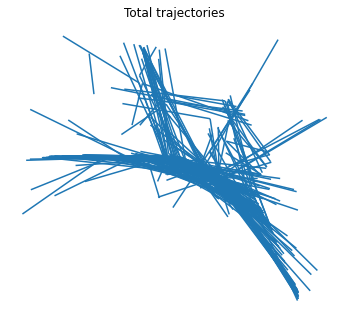

In [74]:
fig, ax = plt.subplots(figsize=(6, 6))
gdf.plot(ax=ax)
ax.axis('off')
ax.set_title('Total trajectories')

## Generate to explain sample 

The process of using trajectory to generate in-out flow is in paper definition 2.

Trajectory flow splicing. Let G be the flow matrix in the range of all the time. Each trajectory can be split by time interval as a tensor. Let $\Omega$ be the set of all trajectories, $T_{i} \in \Omega$ denotes a trajectory. $T_{i}^{i n}$ and $T_{i}^{\text {out }}$ refer to a transfer presentation by the following constraint condition
\begin{align*}
\begin{aligned}
T_{r}^{i n, i, j} &=\left|\left\{k>1 \mid v_{k-1} \notin(i, j) \wedge v_{k} \in(i, j)\right\}\right| \\
T_{r}^{o u t, i, j} &=\left|\left\{k \geq 1 \mid v_{k} \in(i, j) \wedge v_{k+1} \notin(i, j)\right\}\right|
\end{aligned}
\end{align*}
Therefore, $G^{i n}$ and $G^{\text {out }}$ would be defined as
\begin{align*}
G^{i n}=\sum_{T_{r}^{i n} \in \Omega} T_{r}^{i n}, \quad G^{o u t}=\sum_{T_{r}^{o u t} \in \Omega} T_{r}^{o u t}
\end{align*}

In [7]:
X,traj_list=Generate_flow(traj_line,drop)
To_explain=np.concatenate([np.sum(x,axis=0) for x in X],axis=0)[np.newaxis]/216

## Deep shap explain

While we have extracted the trajectory flow tensor and reduce the computational complexity from $O\left(2^{d \times H \times W}\right)$ to $O\left(2^{N}\right),$ within a certain time slot, there may be millions of trajectories in the city. The computational complexity is still large. Fortunately, Deep SHAP is a high-speed approximation algorithm for SHAP values in deep learning models that build on a connection with DeepLIFT. The trajectory Shapley can obtain with $O(N)$ complexity. In crowd prediction, Deep SHAP could be formulated as
\begin{align*}
\left.\phi\left(\mathcal{V}_{t^{\prime}}\right)=\left(\mathcal{Y}_{t+1}-\mathbb{E}\left[\boldsymbol{y}_{t+1}\right]\right)\right) \times \frac{\partial\left(\boldsymbol{y}_{t+1}^{x, y}\right)}{\partial \boldsymbol{V}_{t^{\prime}}}, \quad \mathcal{V}_{t^{\prime}} \in G_{t}
\end{align*}

In [8]:
# load background samples
TrainX, TrainY, TestX, TestY = process_data()

In [9]:
# load CNN model
from CNN import CNN
CNN =torch.load('./model/best_cnn_model.pkl').eval().cuda()

### Explain region
In Chengdu, we chose the intersection of the Second Ring Elevated
Road and Fuqing Road. The speed here is fast and the traffic flow
is large, so it is the place with the largest traffic flow. 
<img src="explain-region.png" width = "400" height = "100" alt="" align=center />

In [10]:
explain_x,explain_y=15,24
class Net(nn.Module):
    def __init__(self,model):
        super(Net, self).__init__()
        self.model  = model

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1,2,38*36)
        return x[:,0,explain_x*36+explain_y:explain_x*36+explain_y+2]

In [11]:
to_explain= torch.nn.Parameter(torch.from_numpy(To_explain).type(torch.FloatTensor).cuda())

In [12]:
model=Net(CNN)

In [13]:
background = torch.from_numpy(TrainX[0][138:138+100]).float().cuda()

In [15]:
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(to_explain)[0]

The process of obtaining $\phi\left(T_{i}\right)$ could be devided by two
step:
- compute the region Shapley $\phi\left(\mathcal{V}_{t^{\prime}}\right)$.
- calculate trajectory Shapley $\phi\left(T_{i}\right)$ with $\phi\left(\mathcal{V}_{t^{\prime}}\right) .$ 
\begin{align*}
\begin{aligned}
\phi\left(T_{i}\right) &\left.=\left(y_{t+1}-\mathbb{E}\left[y_{t+1}\right]\right)\right) \times \frac{\partial\left(y_{t+1}^{x, y}\right)}{\partial T_{i}} \\
&\left.=\left(y_{t+1}-\mathbb{E}\left[y_{t+1}\right]\right)\right) \times \frac{\partial\left(y_{t+1}^{x, y}\right)}{\partial \mathcal{V}_{t^{\prime}}} \times \frac{\partial \mathcal{V}_{t^{\prime}}}{\partial T_{i}} \\
&=\phi\left(\mathcal{V}_{t^{\prime}}\right) \times \frac{\partial \mathcal{V}_{t^{\prime}}}{\partial T_{i}}
\end{aligned}
\end{align*}


In [16]:
# use chain rule to calculate trajectory Shapley
W,H=38,36
grad_tensor=np.zeros([5,W,H])
shapley_values=shap_values[0,0::2]
shaps={}
for _,x in traj_list['inflow'].items():
    weight=0
    for s in x:
        for keys,values in s.items():
            grad_tensor[keys]+=weight*X[keys][values][0]
            weight+=np.sum(shapley_values[keys]*X[keys][values][0])
    shaps[_]=weight

In [20]:
gdf['shap']=list(shaps.values())
gdf['shap']/=np.abs(gdf.shap).max()
Traj_set=gdf[np.abs(gdf.shap)>0.1]
len(Traj_set)

519

Text(0.5, 1.0, 'Explainable subset')

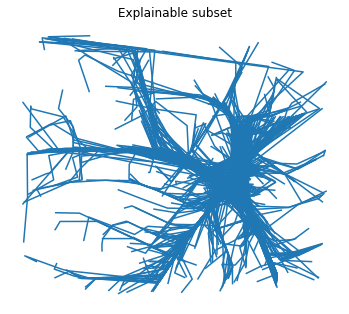

In [21]:
fig, ax = plt.subplots(figsize=(6, 6))
Traj_set.plot(ax=ax)
ax.axis('off')
ax.set_title('Explainable subset')

In [22]:
import numpy as np

from trajCluster.partition import approximate_trajectory_partitioning, segment_mdl_comp, rdp_trajectory_partitioning
from trajCluster.point import Point
from trajCluster.cluster import line_segment_clustering, representative_trajectory_generation
from trajCluster.segment import Segment

In [23]:
trajs=[]
segment=[]
for ids,(_,df) in enumerate(tqdm(Traj_set.iterrows())):
    pre_x,pre_y,trajectory=0,0,[]
    for traj in list(df.geometry.coords):
        if pre_x!=traj[0] or pre_y!=traj[1]:
            trajectory.append(Point(traj[0]*1e5,traj[1]*1e5))
            pre_x,pre_y=traj[0],traj[1]
    trajs.append(trajectory)
    approximate_seg=approximate_trajectory_partitioning(trajectory, theta=20, traj_id=ids+1)
    segment.append(approximate_seg)

In [24]:
segs,track_id,track_line=[],[],[]
for num,seg in enumerate(segment):
    count=0
    for part in seg:
        if part.start.x!=part.end.x or part.start.y!=part.end.y:
            segs.extend([LineString([(part.start.x/1e5,part.start.y/1e5),(part.end.x/1e5,part.end.y/1e5)])])
            track_line.extend([([(part.start.x,part.start.y),(part.end.x,part.end.y)])])
            count+=1
    track_id.extend([num+1]*count)

In [25]:
gdf=gpd.GeoDataFrame(track_id,geometry=segs,columns=['track_id'])

Text(0.5, 1.0, 'Trajectory Segment')

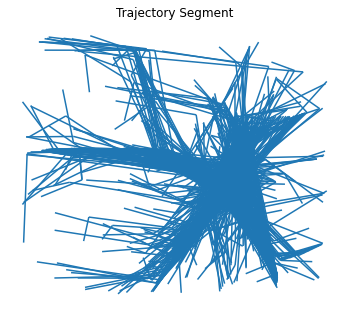

In [26]:
fig, ax = plt.subplots(figsize=(6, 6))
gdf.plot(ax=ax)
ax.axis('off')
ax.set_title('Trajectory Segment')

In [27]:
min_latitude,min_longitude = 30.655,104.041
delta_latitude,delta_longitude = 0.002, 0.0025
seg_shap=[]
for _,df in gdf.iterrows():
    grad=0
    for x,y in list(df['geometry'].coords):
        x=int((x-min_longitude)/delta_longitude)
        y=int((y-min_latitude)/delta_latitude)
        if y>=36:break
        grad+=np.sum(shapley_values[:,x,y])
    seg_shap.append(grad) 
gdf['shap']=seg_shap

In [29]:
gdf=gdf[gdf.shap!=0]

In [30]:
len(set(seg_shap))

89

In [32]:
gdf['shap']/=np.abs(gdf.shap).max()

In [34]:
def sigmoid(x,t):
    return 1/(1+np.exp(-x/t))

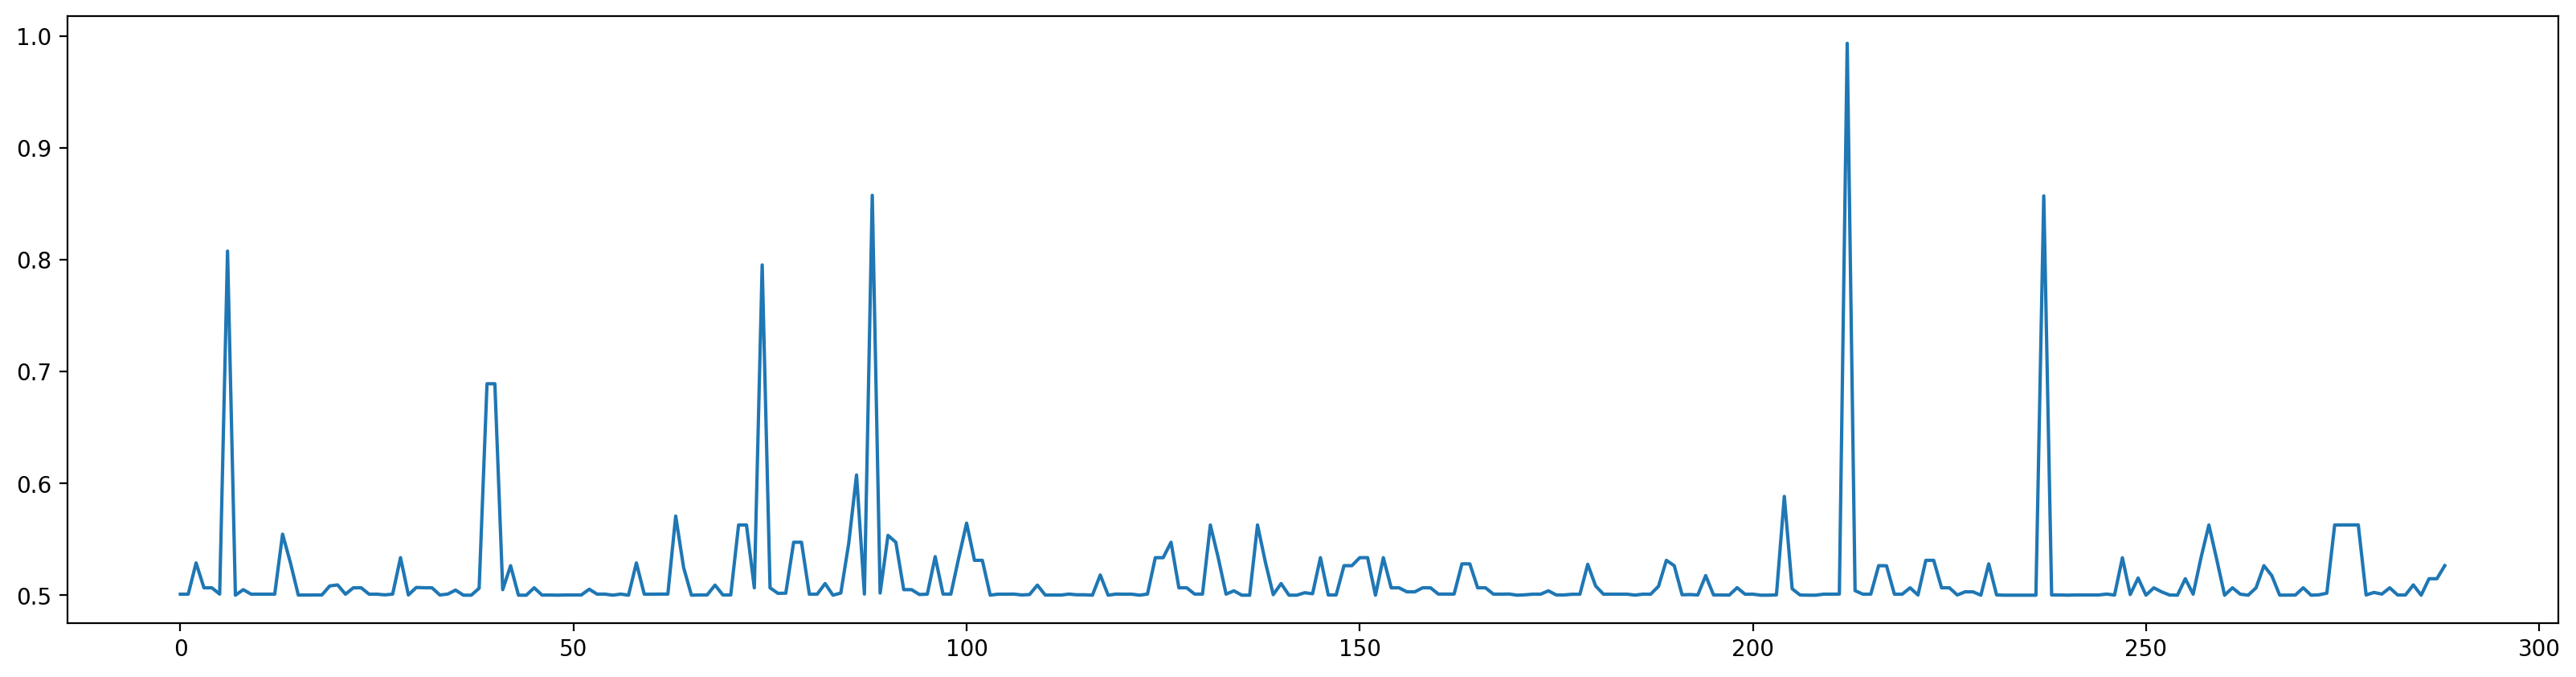

In [35]:
plt.subplots(figsize=(20,5),dpi=200)
plt.plot(sigmoid(gdf.shap.values,0.2))

In [36]:
norm_weights=sigmoid(gdf.shap.values,0.2)

In [37]:
segments=[]
enlarge_distance=1e3
for x in gdf.geometry:
    locs=list(x.coords)
    segments.append(Segment(Point(locs[0][0]*enlarge_distance, locs[0][1]*enlarge_distance), \
                            Point(locs[1][0]*enlarge_distance, locs[1][1]*enlarge_distance)))

The asymmetric distance formula in trajectory submodular for two sub trajectories $L_{i}$ and $L_{j}$ as
\begin{align}
d_{L_{r}}\left(L_{1}, L_{2}\right)=\frac{\lambda_{\theta} d_{\theta}\left(L_{1}, L_{2}\right)+\lambda_{\perp} d_{\perp}\left(L_{1}, L_{2}\right)+\lambda_{s} d_{s}\left(\phi\left(L_{1}\right), \phi\left(L_{2}\right)\right)}{\delta\left(\phi\left(L_{r}\right), T\right)}
\end{align}
Where $L_{1}, L_{2} \in L_{r}$. The selection matrix of maximum coverage can be obtained by setting threshold parameters $\omega .$  Note that $\lambda_{\theta}, \lambda_{\perp}, \lambda_{s}$ are to control the weight of perpendicular distance, angle distance, and distribution distance respectively.

In [82]:
distance_maxtrix=np.zeros([len(gdf),len(gdf)])
lambda_xita,lambda_perp,lambda_theta=3,5,5
for i,(x,weights_1) in tqdm(enumerate(zip(segments,norm_weights))):
    for j,(y,weights_2) in enumerate(zip(segments[i+1:],norm_weights[i+1:]),start=i+1):
        dist=x.parallel_distance(y)*lambda_xita+x.angle_distance(y)*lambda_perp
        distance_maxtrix[i,j]=(dist+np.power((weights_2-weights_1),2)*enlarge_distance*lambda_theta)/weights_1
        distance_maxtrix[j,i]=(dist+np.power((weights_2-weights_1),2)*enlarge_distance*lambda_theta)/weights_2

In [83]:
distance_maxtrix[distance_maxtrix==0]=np.inf

In [84]:
W_omega=8 # Eight hundred percent
fliter=np.percentile(distance_maxtrix,W_omega)
distance_maxtrix[distance_maxtrix<=fliter]=-1
distance_maxtrix[distance_maxtrix>fliter]=0
distance_maxtrix[distance_maxtrix==-1]=1

### Max (Set) Coverage

The maximum coverage problem refers to the selection of $k$ elements that are each described by a set of numbers such that the union of these sets has the maximal size. Phrased differently, when applied to binary data, the maximum coverage problem refers to the selection of $k$ elements such that the most columns have at least one element with a non-zero value. Formally, this problem is 

\begin{equation}
f(X) = \sum\limits_{i=1}^{d} \left(\left( \sum\limits_{x \in X} x_{i} \right) > 0 \right)
\end{equation}
where $f$ denotes the maximum coverage function, $X$ is the set of selected examples and $d$ is the number of dimensions in the data. 


In [85]:
num_example=10
model = MaxCoverageSelection(num_example)
X_hat = model.fit_transform(distance_maxtrix)

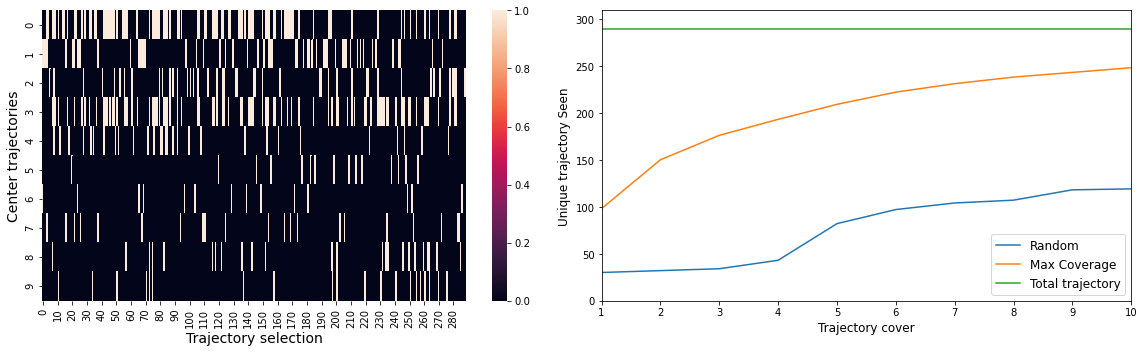

In [86]:
import matplotlib.pyplot as plt
import random
plt.figure(figsize=(16, 5))
plt.subplot(121)
sns.heatmap(X_hat)
plt.xlabel("Trajectory selection", fontsize=14)
plt.ylabel("Center trajectories", fontsize=14)
#plt.ylim(0, len(kernel_matrix))
plt.grid(False)
random = random.sample(range(1, len(distance_maxtrix)), num_example)
number=100
plt.subplot(122)
plt.plot(np.arange(num_example)+1,(np.cumsum(distance_maxtrix[random], axis=0) > 0).sum(axis=1), label="Random")
plt.plot(np.arange(num_example)+1,(np.cumsum(X_hat, axis=0) > 0).sum(axis=1), label="Max Coverage")
plt.plot(np.arange(num_example)+1,np.ones((num_example,1))*len(distance_maxtrix), label="Total trajectory")
plt.xlabel("Trajectory cover", fontsize=12)
plt.ylabel("Unique trajectory Seen", fontsize=12)
plt.xlim(1, num_example)
plt.ylim(0, len(distance_maxtrix)+20)
plt.legend(fontsize=12)
plt.xticks(np.arange(num_example)+1)
plt.tight_layout()
plt.show()

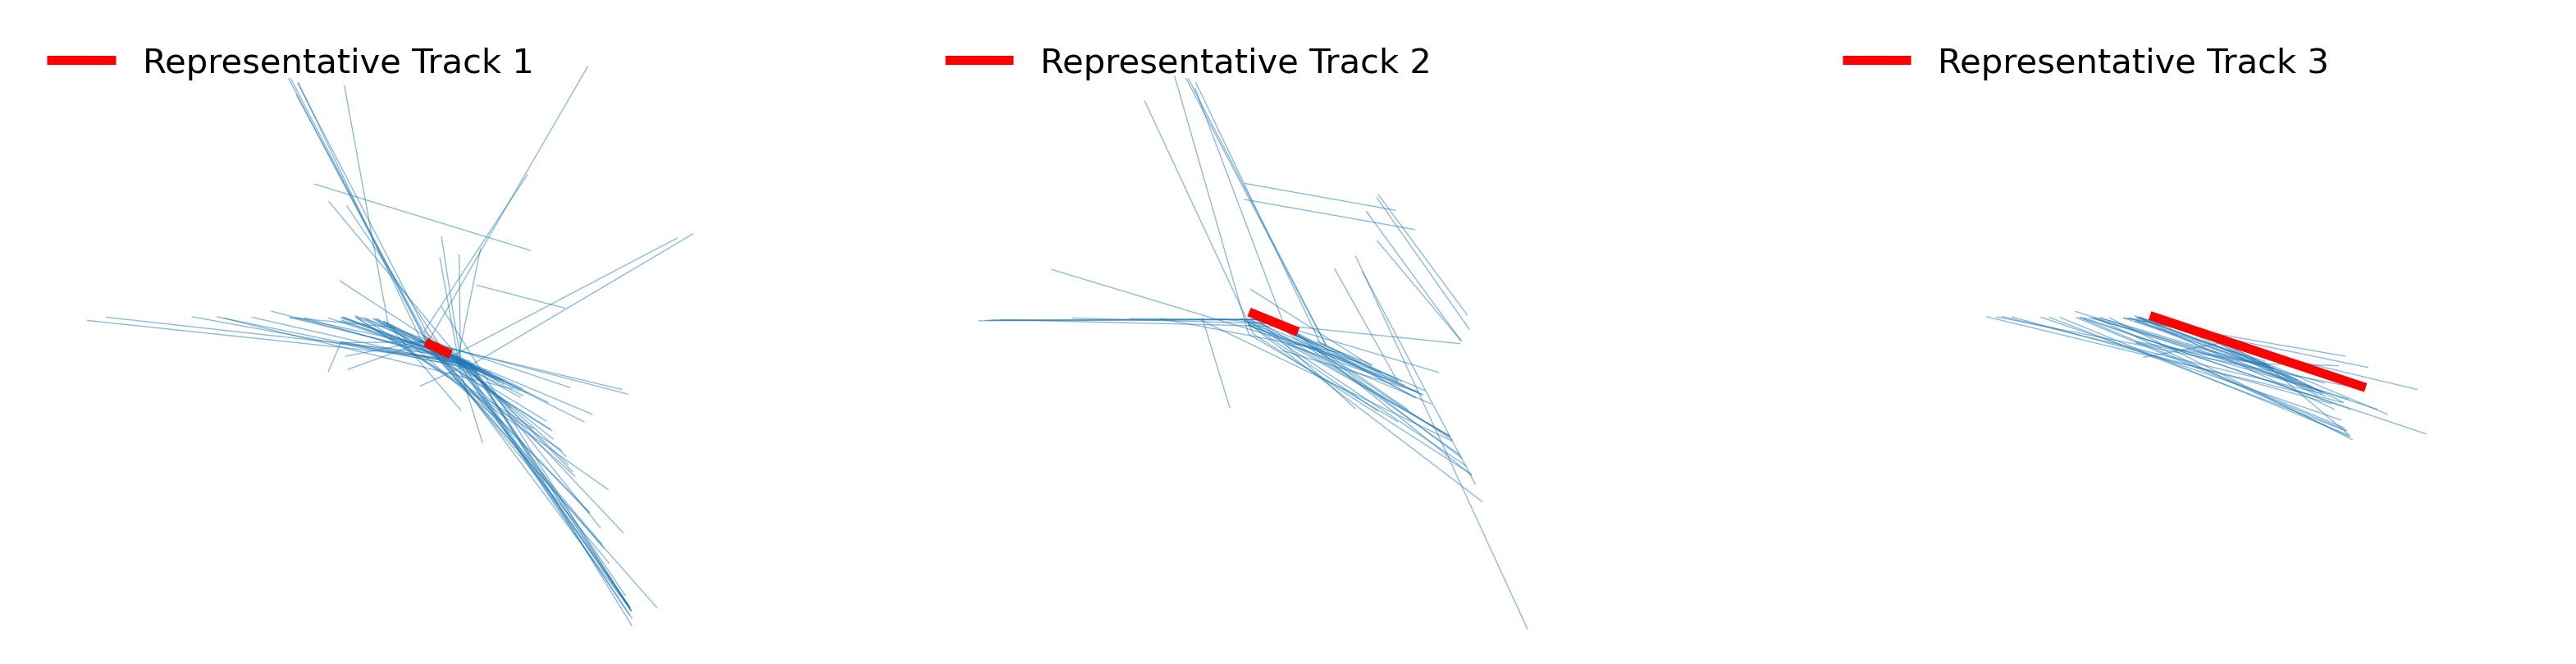

In [87]:
#fig = plt.figure()
#min_latitude,min_longitude = 30.655,104.041
number_examples=3
fig,ax = plt.subplots(1,3,figsize=(20, 10),dpi=200)
for i,ids in  enumerate(model.ranking[:number_examples]):
    gdf[distance_maxtrix[ids]==1].plot(ax=ax[i],alpha=0.5,linewidth=0.5)
    ax[i].set_xlim(min_longitude,min_longitude+0.0025*36)
    ax[i].set_ylim(min_latitude,min_latitude+0.002*38)
for i,ids in  enumerate(model.ranking[:number_examples]):
    gdf.iloc[ids:ids+1].plot(ax=ax[i],edgecolor='r',linewidth=4,label="Representative Track "+str(i+1))
    ax[i].legend(loc=2,frameon=False,fontsize=15)
    ax[i].axis('off')

(104.0450345, 104.12611549999998, 30.653822999999992, 30.728337000000003)

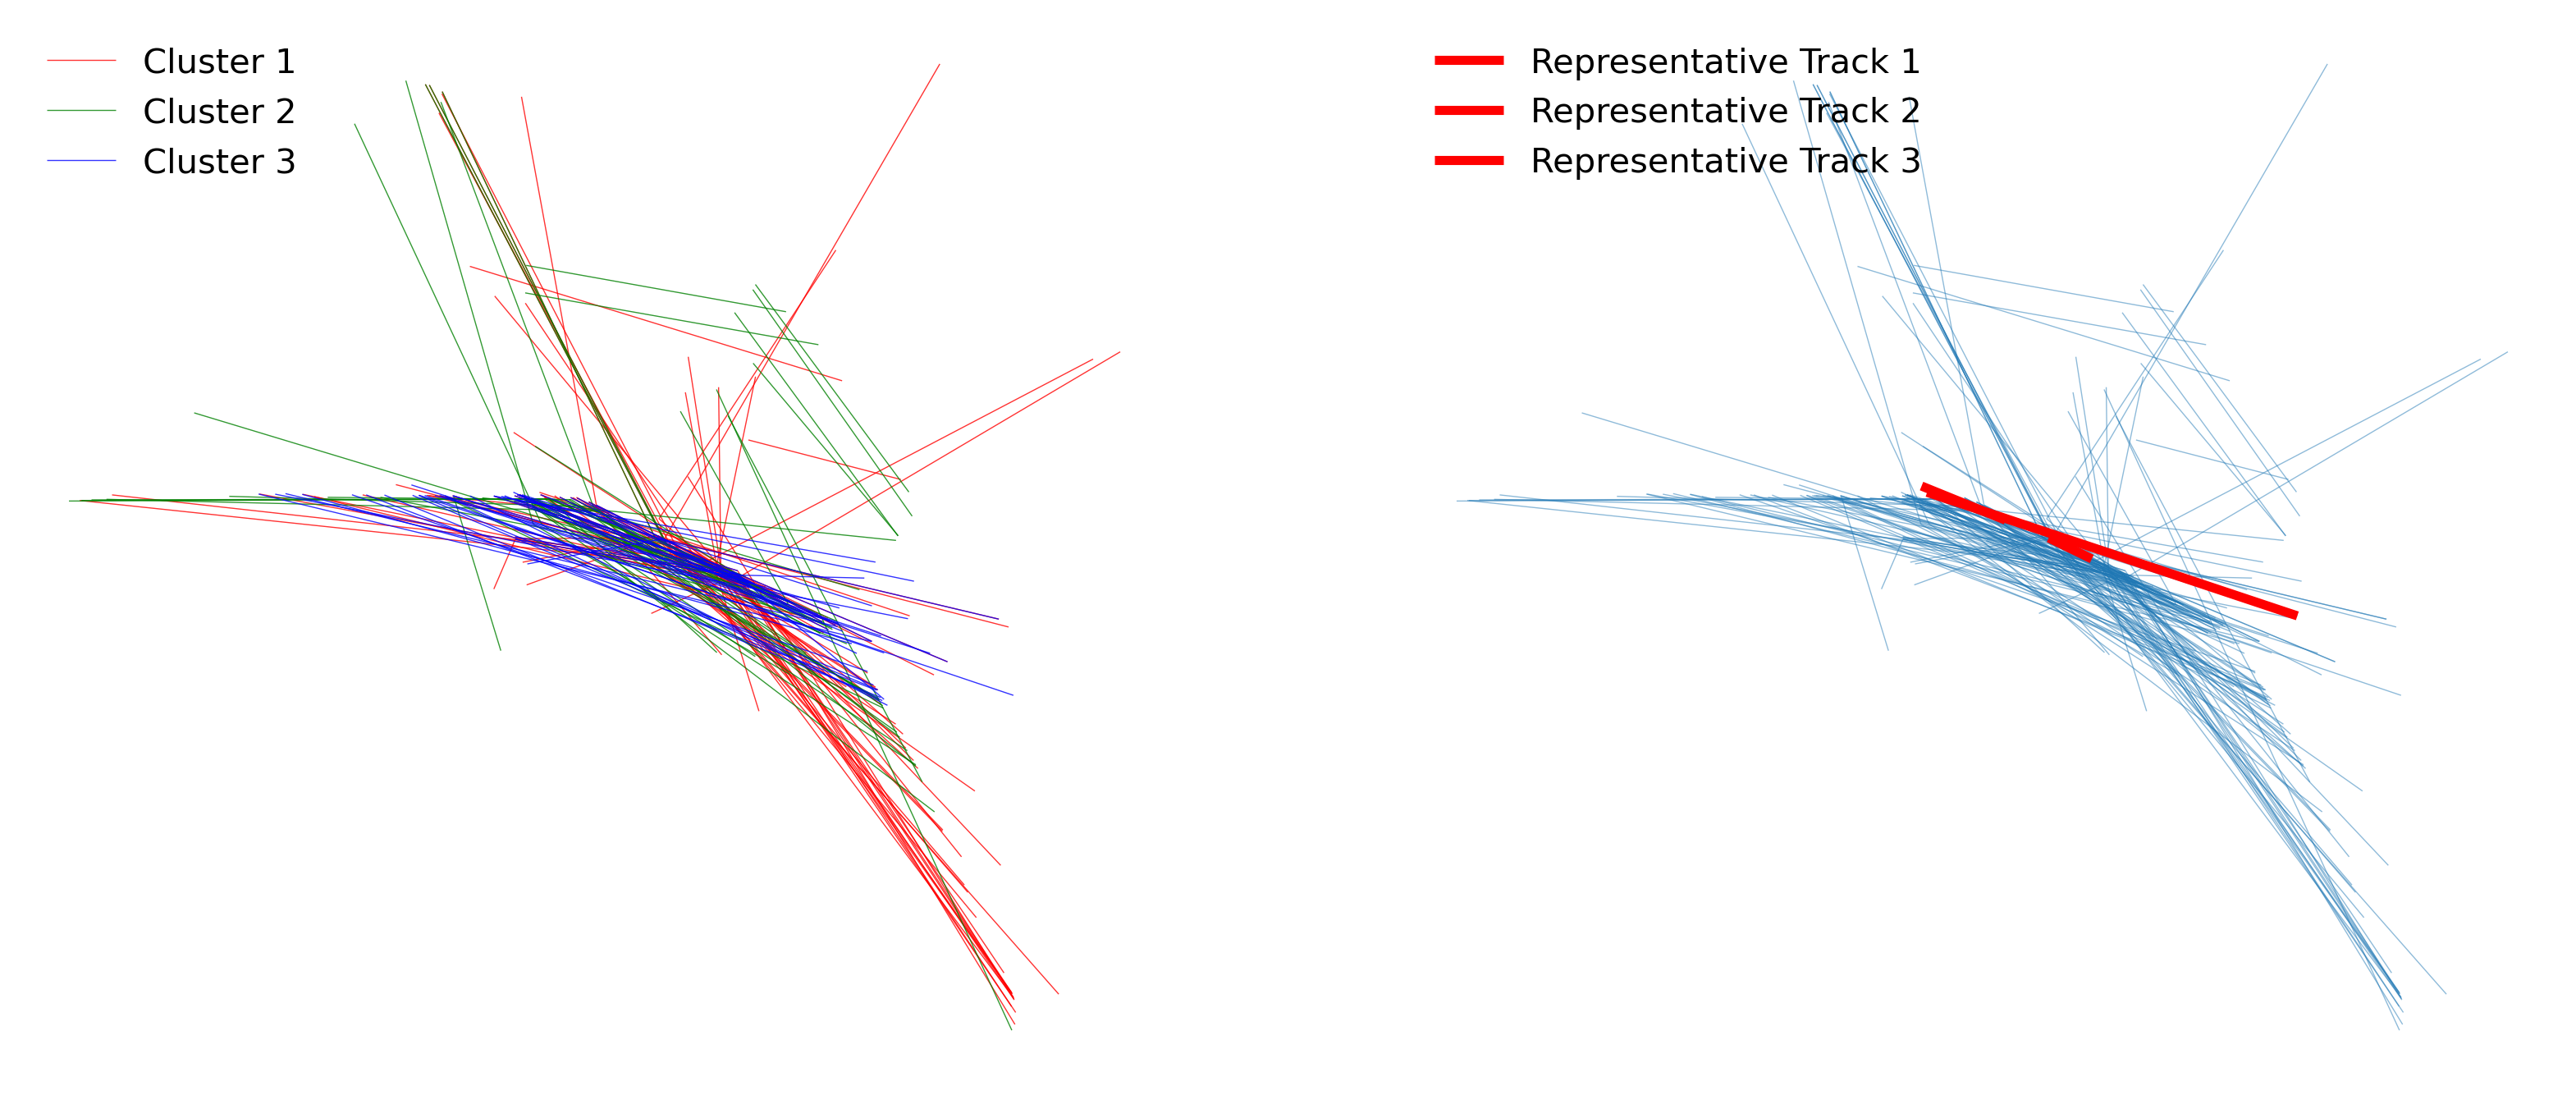

In [88]:
fig,ax = plt.subplots(1,2,figsize=(20, 10),dpi=200)
#gdf.plot(ax=ax)
number_examples=3
colors=['r','g','b','sandybrown']
for i,ids in  enumerate(model.ranking[:number_examples]):
    gdf[distance_maxtrix[ids]==1].plot(ax=ax[0],alpha=0.8,edgecolor=colors[i],linewidth=0.5,label='Cluster '+str(i+1) )
ax[0].axis('off')
ax[0].legend(loc=2,frameon=False,fontsize=15)
ax[0].set_xlabel('a) Sumodular cover')
for i,ids in  enumerate(model.ranking[:number_examples]):
    gdf[distance_maxtrix[ids]==1].plot(ax=ax[1],alpha=0.5,linewidth=0.5)
for i,ids in  enumerate(model.ranking[:number_examples]):
    gdf.iloc[ids:ids+1].plot(ax=ax[1],edgecolor='r',linewidth=4,label="Representative Track "+str(i+1))
ax[1].legend(loc=2,frameon=False,fontsize=15)
ax[1].axis('off')
#ax[1].set_xlabel('b) Representative Track')
#plt.savefig('result/cluster.pdf', bbox_inches='tight')

In [89]:
import folium.plugins
import branca
import branca.colormap as cm
from tqdm.notebook import tqdm
from branca.element import Figure
from transform_gps import gcj02towgs84
import math
base_lat = (30.654470467968622+30.73343515437288)/2
base_lon = (104.0385528416383+104.1284721861233)/2
fig5=Figure(height=550,width=750)
fname = 'chengdu_road_heatmap.html'
attr = (
    '&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> '
    'contributors, &copy; <a href="http://cartodb.com/attributions">CartoDB</a>'
)
colors=['red','green','blue']
tiles = "http://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png"
m=folium.Map(location=[base_lat,base_lon], tiles=tiles,attr=attr, zoom_start=13,zoom_control=1,no_touch=True)
fig5.add_child(m)
colormap = cm.LinearColormap(colors=['darkblue', 'blue', 'cyan', 'yellow', 'orange', 'red'], vmin=0, vmax=1)
# Adding lines to the different feature groups
number_examples=[0,1,2]
for i,ids in  enumerate(model.ranking[:3]):
    subset=gdf[distance_maxtrix[ids]==1]
    for j in tqdm(range(subset.shape[0])):
        location=list(subset.geometry.values[j].coords)
        shapley_values=subset.iloc[j].shap
        location[0]=gcj02towgs84(*location[0])
        location[1]=gcj02towgs84(*location[1])
        location=np.rot90(np.array(location), 2).tolist()
        if i==0:shapley_values*=20
        folium.vector_layers.PolyLine(location,weight=shapley_values*10,color=colors[i],opacity=1).add_to(m)
        location=np.array(location)
        diff_vector=location[1]-location[0]
        if 90*math.atan(diff_vector[0]/diff_vector[1])<0:
            folium.RegularPolygonMarker(location=location[1].tolist(), fill_color='blue',opacity=1,number_of_sides=3, radius=shapley_values*5,\
                                        rotation=90*math.atan(diff_vector[0]/diff_vector[1])).add_to(m)
        #folium.vector_layers.PolyLine(location,weight=1).add_to(m)
folium.LayerControl().add_to(m)
#m.add_child(colormap)
m.fit_bounds(30.654470467968622,104.0385528416383,30.73343515437288,104.1284721861233)
m

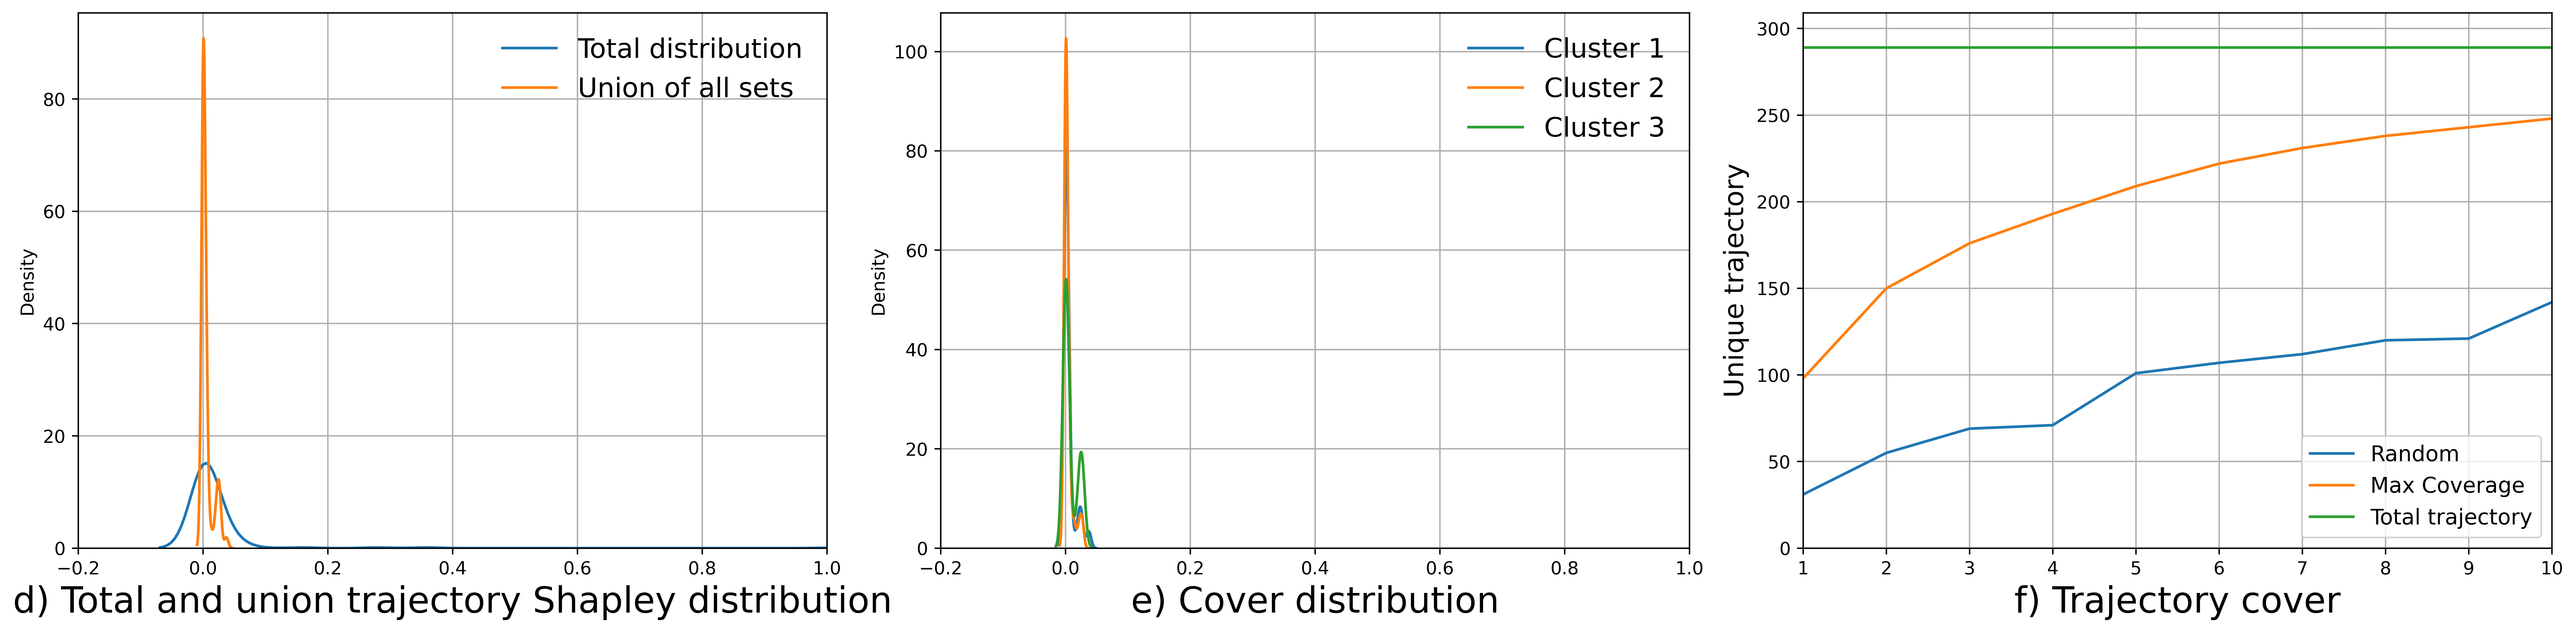

In [90]:
fig,ax = plt.subplots(1,3,figsize=(20,5),dpi=500)
import warnings
warnings.filterwarnings('ignore')
sns.distplot(pd.DataFrame(gdf.shap).T, hist=False,ax=ax[0],label='Total distribution')
all_distributon=[]
number_examples=[0,1,2]
for i,ids in  enumerate(model.ranking[number_examples]):
    sns.distplot(pd.DataFrame(gdf[distance_maxtrix[ids]==1].shap).T, hist=False,ax=ax[1],label='Cluster '+str(i+1))
    all_distributon.append(pd.DataFrame(gdf[distance_maxtrix[ids]==1].shap))
all_distributon=pd.concat(all_distributon)
sns.distplot(all_distributon.shap, hist=False,ax=ax[0],label='Union of all sets')                         
ax[1].legend(frameon=False,fontsize=15)
ax[1].set_xlim(-0.2,1)
ax[1].set_xlabel('e) Cover distribution',fontsize=20)
ax[0].set_xlim(-0.2,1)
ax[0].set_xlabel('d) Total and union trajectory Shapley distribution',fontsize=20)
ax[0].legend(frameon=False,fontsize=15)
ax[0].grid('on')
ax[1].grid('on')
#plt.show()
number=200
random = np.argsort(np.sum(distance_maxtrix,axis=1))[number:number+num_example]
np.random.shuffle(random)
ax[2].plot(np.arange(num_example)+1,(np.cumsum(distance_maxtrix[random], axis=0) > 0).sum(axis=1), label="Random")
ax[2].plot(np.arange(num_example)+1,(np.cumsum(X_hat, axis=0) > 0).sum(axis=1), label="Max Coverage")
ax[2].plot(np.arange(num_example)+1,np.ones((num_example,1))*len(distance_maxtrix), label="Total trajectory")
ax[2].set_xlabel("f) Trajectory cover", fontsize=20)
ax[2].set_ylabel("Unique trajectory", fontsize=15)
ax[2].set_xlim(1, num_example)
ax[2].set_ylim(0, len(distance_maxtrix)+20)
ax[2].legend(fontsize=12)
#ax[2].set_xticks(np.arange(num_example)+1)
plt.tight_layout()
plt.grid('on')
plt.savefig('distribution_even.pdf', bbox_inches='tight')
plt.show()